## 图像预处理
### 分布式环境下TensorFlow文件读取方式

在分布式环境下（例如阿里云的PAI中），文件的存储方式与本地中不同，无法使用Python`open()`, `os.path.exist()`等文件操作。读取文件需要使用Tensorflow提供的**分布式文件读取方式**，如**tf.gfile.FastGfile()（小规模）**，**tf.WhoFileReader()（大批量）**等。

以下是`tf.gfile.FastGFile`的使用案例。

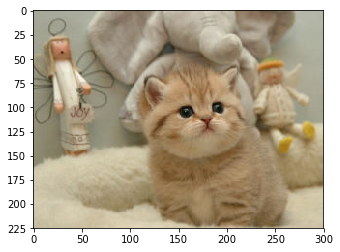

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf

# 读取时推荐使用rb方式读取
image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

with tf.Session() as sess:
    # 将图片的raw转化为Tensor
    img_data = tf.image.decode_jpeg(image_raw_data)
    # Tensor调用eval()函数后会返回一个ndarray，可以被matplotlib绘制
    plt.imshow(img_data.eval())
    plt.show()
    
    # 将数据的类型转化成实数方便对图像进行处理
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    
    # 处理完成后必须转回uint8格式的Tensor才能encode为image并保存
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.uint8)
    
    encoded_image = tf.image.encode_jpeg(img_data)
    
    with tf.gfile.GFile('./image/cat_rewrite.jpg', 'wb') as img:
        img.write(encoded_image.eval())

### 图像大小调整
图像大小调整有三种方式。

第一种是通过算法使得新的图像尽量保存原始图像上的所有信息。Tensorflow提供了四种不同方法，并将它们封装到了`tf.image.resize_images`中。

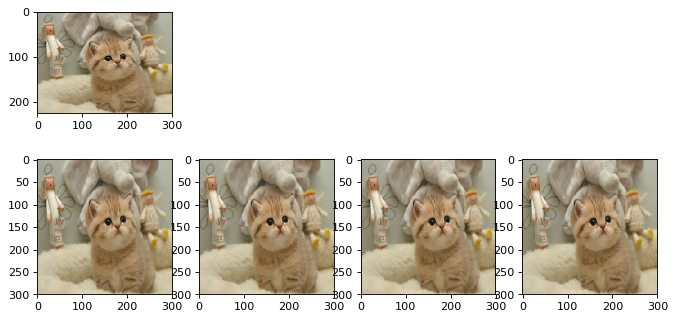

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf

image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    
    plt.figure(figsize=(10, 5), dpi=80)
    plt.subplot(2,4,1)
    plt.imshow(img_data.eval())
    
    # 将数据的类型转化成实数方便对图像进行处理
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)
    
    # 调整图像大小，method参数给出了调整图像大小的算法。不同算法调整出来的
    # 结果会有细微差别，但不会相差太远。
    # 0：双线性插值
    # 1：最临近法
    # 2：双三次插值法
    # 3：面积插值法
    resized0 = tf.image.resize_images(img_data, (300, 300), method=0)
    resized1 = tf.image.resize_images(img_data, (300, 300), method=1)
    resized2 = tf.image.resize_images(img_data, (300, 300), method=2)
    resized3 = tf.image.resize_images(img_data, (300, 300), method=3)
    
    resized0 = tf.image.convert_image_dtype(resized, dtype=tf.uint8)
    resized1 = tf.image.convert_image_dtype(resized, dtype=tf.uint8)
    resized2 = tf.image.convert_image_dtype(resized, dtype=tf.uint8)
    resized3 = tf.image.convert_image_dtype(resized, dtype=tf.uint8)
    
    plt.subplot(2,4,5)
    plt.imshow(resized0.eval())
    plt.subplot(2,4,6)
    plt.imshow(resized1.eval())
    plt.subplot(2,4,7)
    plt.imshow(resized2.eval())
    plt.subplot(2,4,8)
    plt.imshow(resized3.eval())
    
    plt.show()

第二种是通过**tf.image.resize_iamge_with_crop_or_pad**函数调整图像大小。该函数第一个参数为原始图像，后面两个参数是调整后的目标图像大小。如果原始图像尺寸大于目标图像，那么该函数会自动截取原始图像中**居中的部分**。如果目标图像大于原始图像，这个函数会自动在原始图像四周填充全0背景。

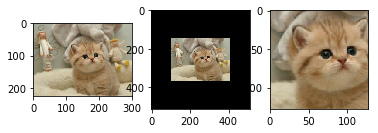

In [19]:
image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)

    plt.subplot(1,3,1)
    plt.imshow(img_data.eval())
    
    croped = tf.image.resize_image_with_crop_or_pad(img_data, 512, 512)
    padded = tf.image.resize_image_with_crop_or_pad(img_data, 128, 128)
    
    plt.subplot(1,3,2)
    plt.imshow(croped.eval())
    plt.subplot(1,3,3)
    plt.imshow(padded.eval())

第三种是通过比例调整图像大小。通过**tf.iamge.central_crop**实现。

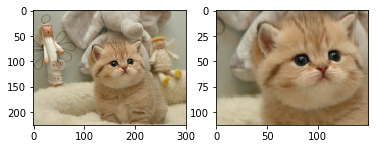

In [21]:
image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)

    plt.subplot(1,2,1)
    plt.imshow(img_data.eval())
    
    central_cropped = tf.image.central_crop(img_data, 0.5)
    plt.subplot(1,2,2)
    plt.imshow(central_cropped.eval())

### 图像翻转

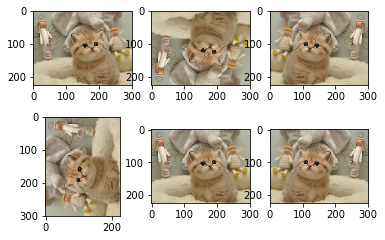

In [23]:
image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)

    plt.subplot(2,3,1)
    plt.imshow(img_data.eval())
    
    # 上下翻转
    flipped_up_down = tf.image.flip_up_down(img_data)
    # 左右翻转
    flipped_left_right = tf.image.flip_left_right(img_data)
    # 对角翻转
    flipped_transposed = tf.image.transpose_image(img_data)
    # 随机上下翻转
    random_up_down = tf.image.random_flip_up_down(img_data)
    # 随机左右翻转
    random_left_right = tf.image.random_flip_left_right(img_data)
    
    plt.subplot(2,3,2)
    plt.imshow(flipped_up_down.eval())
    plt.subplot(2,3,3)
    plt.imshow(flipped_left_right.eval())
    plt.subplot(2,3,4)
    plt.imshow(flipped_transposed.eval())
    plt.subplot(2,3,5)
    plt.imshow(random_up_down.eval())
    plt.subplot(2,3,6)
    plt.imshow(random_left_right.eval())

### 图像色彩调整

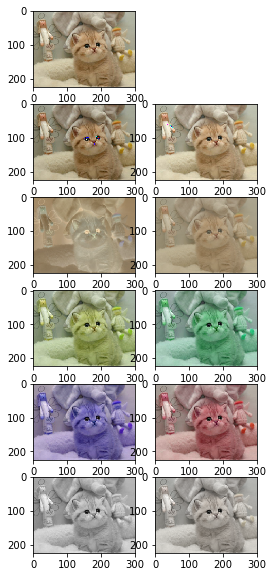

In [42]:
image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

subplot_row = 6
subplot_col = 2

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)

    
    plt.figure(figsize=(4, 10))
    
    plt.subplot(subplot_row,subplot_col,1)
    plt.imshow(img_data.eval())
    
    # 亮度调整
    adjust_brightness1 = tf.image.adjust_brightness(img_data, -0.05)
    adjust_brightness2 = tf.image.adjust_brightness(img_data, 0.05)
    
    plt.subplot(subplot_row,subplot_col,3)
    plt.imshow(adjust_brightness1.eval())
    plt.subplot(subplot_row,subplot_col,4)
    plt.imshow(adjust_brightness2.eval())
    
    # 对比度调整
    adjust_contrast1 = tf.image.adjust_contrast(img_data, -0.5)
    adjust_contrast2 = tf.image.adjust_contrast(img_data, 0.5)
    # 随机对比度。参数：image, lower, upper。lower不能是负数
    random_constrast = tf.image.random_contrast(img_data, 0, 0.5)
    
    plt.subplot(subplot_row,subplot_col,5)
    plt.imshow(adjust_contrast1.eval())
    plt.subplot(subplot_row,subplot_col,6)
    plt.imshow(adjust_contrast2.eval())
    
    # 色相调整
    adjust_hue1 = tf.image.adjust_hue(img_data, 0.1)
    adjust_hue2 = tf.image.adjust_hue(img_data, 0.3)
    adjust_hue3 = tf.image.adjust_hue(img_data, 0.6)
    adjust_hue4 = tf.image.adjust_hue(img_data, 0.9)

    # 随机色相。第二个参数是max_delta，取值在[0, 0.5]之间。函数会在[-max_delta, max_delta]之间取值
    random_hue = tf.image.random_hue(img_data, 0.5)
    
    plt.subplot(subplot_row,subplot_col,7)
    plt.imshow(adjust_hue1.eval())
    plt.subplot(subplot_row,subplot_col,8)
    plt.imshow(adjust_hue2.eval())
    plt.subplot(subplot_row,subplot_col,9)
    plt.imshow(adjust_hue3.eval())
    plt.subplot(subplot_row,subplot_col,10)
    plt.imshow(adjust_hue4.eval())
    
    # 饱和度调整
    adjust_saturation1 = tf.image.adjust_saturation(img_data, -0.2)
    adjust_saturation2 = tf.image.adjust_saturation(img_data, 0.2)
    # 随机饱和度。参数：image, lower, upper。lower不能是负数
    random_saturation = tf.image.random_saturation(img_data, 0.1, 0.2)
    
    plt.subplot(subplot_row,subplot_col,11)
    plt.imshow(adjust_saturation1.eval())
    plt.subplot(subplot_row,subplot_col,12)
    plt.imshow(adjust_saturation2.eval())
        

### 图像标准化
将代表一张图像的三位矩阵中数字均值变为0，方差变为1。使用**per_image_standardization**方法。

In [44]:
image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

subplot_row = 6
subplot_col = 2

with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    img_data = tf.image.convert_image_dtype(img_data, dtype=tf.float32)

    std = tf.image.per_image_standardization(img_data)

### 处理标注框
在很多图像识别的数据集中，图片中需要识别的物体通常会被标注出来。通过**tf.image.draw_bounding_boxes**加入标注框。

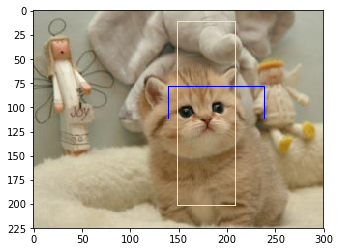

In [24]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt

image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

# tf.image.draw_bounding_boxes函数要求图像矩阵中数字为实数，因此需要
# 先将图像矩阵转化为实数类型。其参数是一个batch数据，也就是多张图片
# 组成的四维矩阵，因此需要现将图像矩阵加一维。
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    
    # 获取图片的维度信息[height, width, channels]，用于绘制标注框时恢复标注框shape
    height, width, channels = img_data.eval().shape
    
    # 将图片数值类型转为float32
    img_data = tf.image.convert_image_dtype(img_data, tf.float32)
    # 拓展图片的batch维
    batched = tf.expand_dims(img_data, 0)
    
    # 标注框的输入参数是一个列表，标注框中每个元素是像素的相对位置。
    # tf.image.draw_bounding_boxes()第一个参数是拓展个数维后的图片数据，
    # 第二个参数是一个3D-Tensor产量，其中每个元素为[ymin, xmin, ymax, xmax]
    boxes = tf.constant([[[0.05, 0.5, 0.9, 0.7], [0.35, 0.47, 0.5, 0.8]]])
    result = tf.image.draw_bounding_boxes(batched, boxes)
    result = tf.image.convert_image_dtype(result, tf.float32)
    
    plt.imshow(img_data.eval())
    # 标注框要绘制前除了要eval，还要reshape
    plt.imshow(result.eval().reshape([height, width, channels]))
    plt.show()

利用**tf.image.sample_distorted_bounding_box(image_size, bounding_boxes)**对图像进行随机截取。

参数：
+ image_size: 一个1-D Tensor。[height, width, channels]。
+ bounding_boxes: 一个类型为float32的3-D Tensor。告诉sample_distorted_bounding_box函数哪些部分有信息量。

返回值：一个Tensor对象元组(begin, size, bboxes)
+ begin: 一个1-D Tensor。[offset_height, offset_width, 0]，截取图像的起点相对于原图左上角的偏移。
+ size: 一个1-D Tensor。[target_height, target_width, -1]，截取图像的size。
+ bboxes: 一个3-D float32 Tensor。绘制标注框用的bbox，作为tf.image.draw_bounding_boxes的参数。

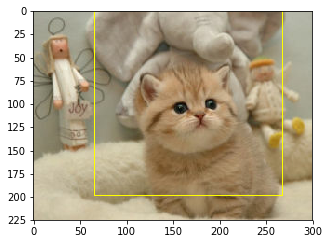

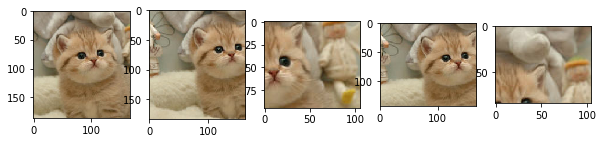

In [48]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt

image_raw_data = tf.gfile.FastGFile('./image/cat.jpg', 'rb').read()

with tf.Session() as sess:
    
    img_data = tf.image.decode_jpeg(image_raw_data)
    
    boxes = tf.constant([[[0.05, 0.5, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    
    # 通过提供标注框的方式告诉随机截取图像哪些部分有信息量
    # tf.shape(image)会返回一个Tensor，sess.run之后获得图片维度[height, weidth, channels]，然后再作为参数传给
    # tf.image.sample_distorted_bounding_box()
    begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(tf.shape(img_data), bounding_boxes=boxes)

    # 拓展图片的batch维
    batched = tf.expand_dims(tf.image.convert_image_dtype(img_data, tf.float32), 0)
    # 绘制标注框box
    image_with_box = tf.image.draw_bounding_boxes(batched, bbox_for_draw)
    
    # 将标注框图片转化为float32类型
    image_with_box = tf.image.convert_image_dtype(image_with_box, tf.float32)
    # 获得原图片的[height, width, channels]
    height, width, channels = sess.run(tf.shape(img_data))
    plt.figure(figsize=(5, 5))
    plt.imshow(img_data.eval())
    # 标注框要绘制前除了要eval，还要reshape
    plt.imshow(image_with_box.eval().reshape([height, width, channels]))
    
    # 随机截取的图像，由于算法带有随机成分，因此每次得到的结果有所不同
    distorted_image = tf.slice(img_data, begin, size)
    
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(distorted_image.eval())
    
    plt.show()